In [11]:
# Import required packages
using DifferentialEquations
using COBREXA
using DataFrames
using Tulip
using Plots
using Colors
using ModelingToolkit
using Statistics
using GLM
using Random
using Flux
using ProgressMeter
using MLBase #Confusion matrix function
using Serialization
using TreeParzen
using CSV
using LatinHypercubeSampling
include("../models/linalool.jl")


linalool (generic function with 1 method)

In [2]:
#LOOP WITHOUT ML SUBSTITUTE OR WARMUP
#Specify algorithm parameters
N = 10 #number of loop iterations
deltat = 1/(60*60) #genetic timescale, seconds -> hr
W = [5, 5, 5, 5] #semi-arbitrary initial promoter values

#Run pre-simulation with initial FBA v_in, v_out lam
model = load_model(StandardModel, "../models/iMM904.xml") #load S.cerevisiae model

Metabolic model of type StandardModel
sparse([66, 297, 338, 389, 1035, 1168, 117, 66, 297, 550  …  66, 341, 835, 1100, 733, 796, 861, 1001, 906, 1069], [1, 1, 1, 1, 1, 1, 2, 3, 3, 3  …  1575, 1575, 1575, 1575, 1576, 1576, 1576, 1576, 1577, 1577], [2.0, -3.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0  …  1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0], 1226, 1577)
Number of reactions: 1577
Number of metabolites: 1226


In [9]:
#Modify model to add dynamic pathway influx 
reaction = Reaction("pathway", Dict("M_mev__R_c" => -1.0))
reaction.lb = 0.0 #Must include lower bound to avoid reaction running backwards with -1000 flux
add_reactions!(model, [reaction])
remove_reactions!(model, ["R_MEVK1", "R_MEVK2", "R_MEVK3", "R_MEVK4", "R_PMEVK", "R_DPMVD", "R_GRTT", "R_IPDDI", "R_DMATT"])

fluxes = flux_balance_analysis_dict(model, Tulip.Optimizer)
lam = fluxes["R_BIOMASS_SC5_notrace"]

v_in_hmgcoa = - fluxes["R_HMGCOAS"] - fluxes["R_HMGCOAtm"] 
v_ipp = - fluxes["R_FRTT"] - fluxes["R_GGTT"] - fluxes["R_IPDPtm"]
v_fpp = - fluxes["R_FRTT"] - 2*fluxes["R_SQLS"] - fluxes["R_FRDPtm"]
#Define param vector to include decision variables
p = [lam, v_in_hmgcoa, v_ipp, v_fpp, W]

5-element Vector{Any}:
  1.4930807513077574e-14
  0.004240812856466304
 -4.279927796849126e-18
 -1.7524590793066346e-17
   [5, 5, 5, 5]

In [15]:
#instantiate initial times
starttime = 0.
endtime = starttime + deltat
tspan = [starttime, endtime]
savetimes = [starttime, endtime] 
u0 = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.] #hmgcoa, ipp, dmapp, gpp, fpp, linalool, thmgr, idi, erg20, lis
#FBA-ODE optimization loop
ode_data = DataFrame("time" => [0], "hmgcoa" => u0[1], "ipp" => u0[2], "dmapp" => u0[3], "gpp" => u0[4], "fpp" => u0[5], "linalool" => u0[6], "thmgr" => u0[7], "idi" => u0[8], "erg20" => u0[9], "lis" => u0[10], "v_p" => [0], "flag" => [0])
fba_data = DataFrame("time" => [0], "v_in_hmgcoa" => [v_in_hmgcoa], "v_ipp" => [v_ipp],  "v_fpp" => [v_fpp], "lam" => [lam]);

In [21]:
#println("Beginning loop...")
for i in 1:N
    println("Iteration ", i)
    prob = ODEProblem(linalool, u0, tspan, p)
    #Solve ODE
    sol = solve(prob, Rosenbrock23(), reltol=1e-3, abstol=1e-6, saveat=savetimes)

    #Solve for pathway fluxes from final concentrations
    v_p = sol.u[end][7] * michaelismenten(sol.u[end][1], lnl_params("kcat_thmgr_hmgcoa"), lnl_params("km_thmgr_hmgcoa"))

    #Backstop to loop
    if v_p >= v_in_hmgcoa
        ode_data = vcat(ode_data, DataFrame("time" => sol.t[1], "hmgcoa" => sol.u[1][1], "ipp" => sol.u[1][2], "dmapp" => sol.u[1][3], "gpp" => sol.u[1][4], "fpp" => sol.u[1][5], "linalool" => sol.u[1][6], "thmgr" => sol.u[1][7], "idi" => sol.u[1][8], "erg20" => sol.u[1][9], "lis" => sol.u[1][10], "v_p" => v_p, "flag" => [1]))
        v_p = 0.4
        print("Hit backstop")
    else   
        ode_data = vcat(ode_data, DataFrame("time" => sol.t[1], "hmgcoa" => sol.u[1][1], "ipp" => sol.u[1][2], "dmapp" => sol.u[1][3], "gpp" => sol.u[1][4], "fpp" => sol.u[1][5], "linalool" => sol.u[1][6], "thmgr" => sol.u[1][7], "idi" => sol.u[1][8], "erg20" => sol.u[1][9], "lis" => sol.u[1][10], "v_p" => v_p, "flag" => [0]))
    end

    #Solve restricted FBA
    restricted_fluxes = flux_balance_analysis_dict(model, Tulip.Optimizer, modifications = [change_constraint("pathway", lb = v_p, ub = v_p)])
    #Update parameter and timing values
    lam = restricted_fluxes["R_BIOMASS_SC5_notrace"]
    v_in_hmgcoa = - fluxes["R_HMGCOAS"] - fluxes["R_HMGCOAtm"] 
    v_ipp = - fluxes["R_FRTT"] - fluxes["R_GGTT"] - fluxes["R_IPDPtm"]
    v_fpp = - fluxes["R_FRTT"] - 2*fluxes["R_SQLS"] - fluxes["R_FRDPtm"]
    
    p = [lam, v_in_hmgcoa, v_ipp, v_fpp, W]

    starttime = endtime
    endtime = starttime + deltat
    tspan = [starttime, endtime]
    savetimes = [starttime, endtime]

    u0 = sol.u[end]
    #Save FBA data
    fba_data = vcat(fba_data, DataFrame("time" => [starttime], "v_in_hmgcoa" => [p[2]], "v_ipp" => [p[3]], "v_fpp" => [p[4]], "lam" => [p[1]]))
end

Iteration 1


┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/charlotte/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/charlotte/.julia/packages/SciMLBase/m11uN/src/integrator_interface.jl:496


Iteration 2
Iteration 3


┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/charlotte/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/charlotte/.julia/packages/SciMLBase/m11uN/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/charlotte/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/charlotte/.julia/packages/SciMLBase/m11uN/src/integrator_interface.jl:496


Iteration 4


┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/charlotte/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/charlotte/.julia/packages/SciMLBase/m11uN/src/integrator_interface.jl:496


Iteration 5


┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/charlotte/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/charlotte/.julia/packages/SciMLBase/m11uN/src/integrator_interface.jl:496


Iteration 6


┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/charlotte/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/charlotte/.julia/packages/SciMLBase/m11uN/src/integrator_interface.jl:496


Iteration 7
Iteration 8


┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/charlotte/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/charlotte/.julia/packages/SciMLBase/m11uN/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/charlotte/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/charlotte/.julia/packages/SciMLBase/m11uN/src/integrator_interface.jl:496


Iteration 9
Iteration 10


┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/charlotte/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/charlotte/.julia/packages/SciMLBase/m11uN/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/charlotte/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/charlotte/.julia/packages/SciMLBase/m11uN/src/integrator_interface.jl:496


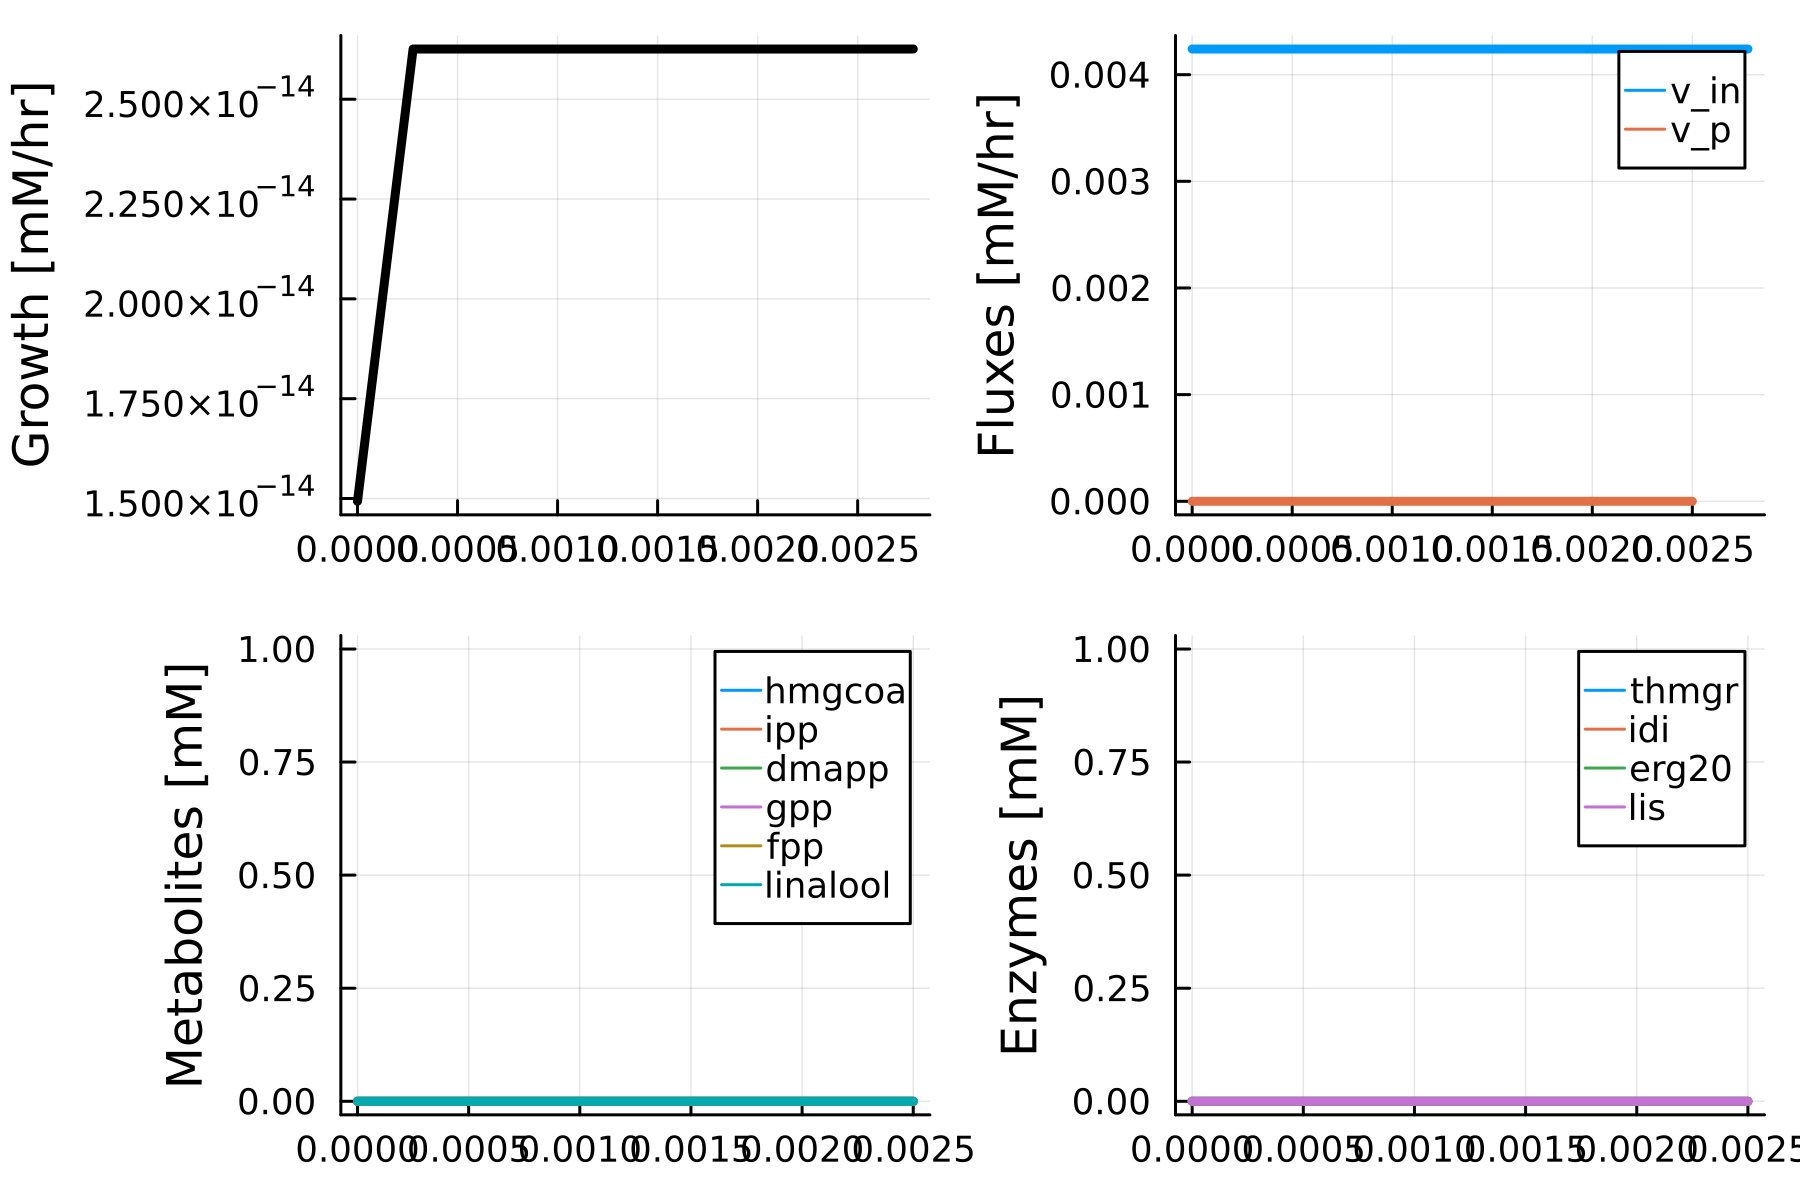

In [22]:
p1 = plot(fba_data.time, [fba_data.lam], ylabel = "Growth [mM/hr]", lw = 3, legend=false, linecolor="black")
p2 = plot([fba_data.time, ode_data.time], [fba_data.v_in_hmgcoa, ode_data.v_p], ylabel = "Fluxes [mM/hr]", lw = 3, label=["v_in" "v_p"], legend=true)
p3 = plot(ode_data.time, [ode_data.hmgcoa, ode_data.ipp, ode_data.dmapp, ode_data.gpp, ode_data.fpp, ode_data.linalool], ylabel = "Metabolites [mM]", lw = 3, label=["hmgcoa" "ipp" "dmapp" "gpp" "fpp" "linalool"], legend=true)
p4 = plot(ode_data.time, [ode_data.thmgr, ode_data.idi, ode_data.erg20, ode_data.lis], ylabel = "Enzymes [mM]", lw = 3, label=["thmgr" "idi" "erg20" "lis"], legend=true)
plot(p1, p2, p3, p4, layout = (2, 2), dpi=300)